In [187]:
import sklearn
import shap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import xgboost as xgb
from tqdm.auto import tqdm
import boruta
# Imports locaux
import coalitional_methods as coal
import drawing
import complete_method as cmpl
import pickle


# Change la taille de la font par défaut de matplotlib
# pour des plots plus lisibles
mpl.rcParams.update({'font.size': 10})

# Définition des méthodes

In [61]:
def generate_correct_explanation(explanation=None,shap_values=None,base_values=None,X=None,look_at=1):
    # Recreate a shap explanation object that can be used for Waterfall plots
    
    if explanation is None:
        if (shap_values is None) | (base_values is None) | (X is None):
            raise Exception("If you pass no explanation, you need to pass shap_values, base_values and X to construct an Explanation object")
            
    if shap_values is None:
        shap_values = explanation.values[:,:,look_at]
    if base_values is None:
        base_values = explanation.base_values[:,look_at]
    if X is None:
        X = pd.DataFrame(explanation.data,columns=explanation.feature_names)
        
    correct_explanation = shap.Explanation(shap_values,
                                         base_values=base_values,
                                         data=X.values,
                                         feature_names=X.columns.to_list())

    return correct_explanation


# The following functions create an explanation object and compute "shap" values as a DataFrame for the 4 methods of interest

def explanation_values_treeSHAP(X, clf, look_at=1):
    explainer = shap.TreeExplainer(clf, X)
    explanation = explainer(X, check_additivity=False)
    explanation = generate_correct_explanation(explanation,look_at=look_at)
    shap_values = pd.DataFrame(explanation.values,
                               columns=X.columns)
    
    return explanation, shap_values


def explanation_values_treeSHAP_approx(X, clf, look_at=1):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X,approximate=True)
    explanation = generate_correct_explanation(shap_values=shap_values[look_at],
                                               base_values=explainer.expected_value[look_at]*np.ones(X.shape[0]),
                                               X=X,
                                               look_at=look_at)
    shap_values = pd.DataFrame(explanation.values,
                               columns=X.columns)
    
    return explanation, shap_values


def explanation_values_kernelSHAP(X, clf, look_at=1):
    explainer = shap.KernelExplainer(clf.predict_proba, X)
    shap_values = explainer.shap_values(X)
    
    explanation = generate_correct_explanation(shap_values=shap_values[look_at],
                                               base_values=explainer.expected_value[look_at]*np.ones(X.shape[0]),
                                               X=X,
                                               look_at=look_at)

    shap_values = pd.DataFrame(shap_values[look_at],
                               columns=X.columns)
    
    return explanation, shap_values

    

def explanation_values_spearman(X, y, clf, rate, problem_type, complexity=False, fvoid=None, look_at=1):
    spearman_inf = coal.coalitional_method(X, y, clf, rate, problem_type, fvoid=fvoid, complexity=complexity, method='spearman', look_at=look_at)
    
    if fvoid is None:
        if problem_type == "Classification":
            fvoid = (
                y.value_counts(normalize=True).sort_index().values
            )  # A NE PAS MODIFIER!
        elif problem_type == "Regression":
            fvoid = y.mean()
    
    explanation = generate_correct_explanation(shap_values=spearman_inf.values,
                                               base_values=fvoid[look_at]*np.ones(X.shape[0]),
                                               X=X,
                                               look_at=look_at)
    
    return explanation, spearman_inf
    
def explanation_values_complete(X, y, clf, problem_type, fvoid=None, look_at=1):
    complete_inf = cmpl.complete_method(X, y, clf, "Classification", fvoid=fvoid, look_at=look_at)
    
    if fvoid is None:
        if problem_type == "Classification":
            fvoid = (
                y.value_counts(normalize=True).sort_index().values
            )  # A NE PAS MODIFIER!
        elif problem_type == "Regression":
            fvoid = y.mean()
            
    explanation = generate_correct_explanation(shap_values=complete_inf.values,
                                               base_values=fvoid[look_at]*np.ones(X.shape[0]),
                                               X=X,
                                               look_at=look_at)
    
    return explanation, complete_inf



# Draw graphs methods

def draw_influence(list_influences, y, list_influences_names=None, labels_names=None):
    if list_influences_names is None:
        list_influences_names=[str(i) for i in range(len(list_influences))]
    if labels_names is None:
        labels_names=["Class"+str(i) for i in range(y.unique().shape[0])]
    
    for i in range(len(list_influences)):
        print(list_influences_names[i] + " :")
        drawing.draw_avg_influence_per_class(list_influences[i], y, labels_name=labels_names)

    plt.bar([i for i in range(len(list_influences)-1)],[(list_influences[0] - list_influences[i]).abs().mean().mean() for i in range(1, len(list_influences))],tick_label=[list_influences_names[i] for i in range(1, len(list_influences))])
    plt.xticks(rotation=30)
    
    for index, value in enumerate([(list_influences[0] - list_influences[i]).abs().mean().mean() for i in range(1, len(list_influences))]):
        plt.text(index, value + 0.001, "%.4f" % value, ha='center', fontweight='bold')
        
    plt.title("Précision de chaque méthode par rapport à {}".format(list_influences_names[0]))
    plt.ylim([plt.ylim()[0],plt.ylim()[1]+0.005])
    
    
def summary_plots(list_shap_values, X, list_names=None):
    if list_names is None:
        list_names=[str(i) for i in range(len(list_shap_values))]
        
    for i,shap_value in enumerate(list_shap_values):
        plt.figure()
        shap.summary_plot(shap_value.values,X,show=False)
        plt.title(list_names[i])
        plt.show();
        
        
def sort_by_influence(df,ascending=True):
    return df.sort_index(key=lambda x:df.loc[:,x].abs().mean(),axis=1, ascending=ascending)


def partial_dependance_plots(list_shap_values,X,list_names=None):
    if list_names is None:
        list_names=[str(i) for i in range(len(list_shap_values))]
    
    for var in sort_by_influence(list_shap_values[0],ascending=False).columns:
        fig, axes = plt.subplots(1,len(list_shap_values), sharey=True, figsize=(5*len(list_shap_values),6))
        for i,shap_values in enumerate(list_shap_values):
            shap.dependence_plot(var,shap_values.values,X,interaction_index=None,show=False,x_jitter=0.5,alpha=1,ax=axes[i])
            axes[i].set_xlabel(list_names[i])
            if i>0:
                axes[i].set_ylabel(None)
        fig.suptitle(var)
        
        
def waterfall_plots(list_explanations, clf, X, list_names=None, indiv=None):
    if list_names is None:
        list_names=[str(i) for i in range(len(list_shap_values))]
    if indiv is None:
        indiv = random.randint(0,X.shape[0]-1)
        
    ncols=2
    nrows=int(np.ceil(len(list_explanations)/2))
    fig = plt.figure(figsize=(60,15*nrows))
    print(clf.predict_proba(X.iloc[indiv].values.reshape(1, -1)))
    
    for i in range(len(list_explanations)):
        fig.add_subplot(nrows,ncols,i+1,title=list_names[i])
        shap.waterfall_plot(list_explanations[i][indiv],max_display=100,show=False)

        fig.set_figheight(15)
        fig.set_figwidth(20)
        fig.tight_layout()
        
        
def waterfall_plots_comparison(list_explanations, clf, X, list_names=None, indiv=None):
    # Compare each waterfall plot to the first one, plotting the difference for each variable
    
    if list_names is None:
        list_names=[str(i) for i in range(len(list_shap_values))]
    if indiv is None:
        indiv = random.randint(0,X.shape[0]-1)
        
    ncols=2
    nrows=int(np.ceil((len(list_explanations)-1)/2))
    fig = plt.figure(figsize=(60,15*nrows))
    print(clf.predict_proba(X.iloc[indiv].values.reshape(1, -1)))
    
    for i in range(1,len(list_explanations)):
        fig.add_subplot(nrows,ncols,i,title=list_names[0]+" - "+list_names[i])
        shap.waterfall_plot(list_explanations[0][indiv] - list_explanations[i][indiv],max_display=100,show=False)

        fig.set_figheight(15)
        fig.set_figwidth(20)
        fig.tight_layout()

# Application à Iris

In [3]:
dataset = sklearn.datasets.load_iris()
X, y = pd.DataFrame(dataset.data, columns=dataset.feature_names), pd.Series(dataset.target)

In [4]:
X.shape

(150, 4)

In [5]:
clf = sklearn.ensemble.RandomForestClassifier()
clf.fit(X,y)

RandomForestClassifier()

In [6]:
%%time

explanation, shap_values = explanation_values_treeSHAP(X, clf, look_at=1)

Wall time: 479 ms


In [7]:
%%time

explanation_approx, shap_values_approx = explanation_values_treeSHAP_approx(X, clf, look_at=1)

Wall time: 0 ns


In [8]:
%%time

explanation_kernel, shap_values_kernel = explanation_values_kernelSHAP(X, clf, look_at=1)

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Wall time: 6.13 s


In [9]:
%%time

explanation_spearman, spearman_inf = explanation_values_spearman(X, y, clf, 0.25, "Classification", complexity=True, look_at=1)

Raw influences: 100%|██████████| 6/6 [00:00<00:00, 128.01it/s]


Wall time: 817 ms


In [10]:
%%time

explanation_complete, complete_inf = explanation_values_complete(X, y, clf, "Classification", look_at=1)

Raw influences: 100%|██████████| 16/16 [00:00<00:00, 104.57it/s]


Wall time: 1.6 s


## Average attribute influence

In [11]:
list_shap_values = [complete_inf,spearman_inf,shap_values,shap_values_approx,shap_values_kernel]
list_names = ["Complete","Spearman25","TreeSHAP","TreeSHAP approx","KernelSHAP"]
list_explanations = [explanation_complete,explanation_spearman,explanation,explanation_approx,explanation_kernel]

Complete :


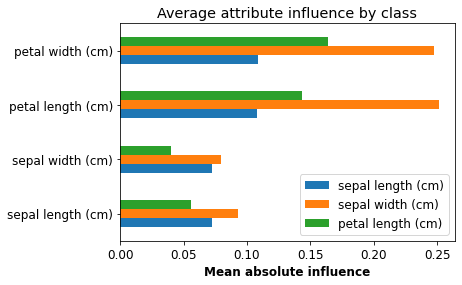

Spearman25 :


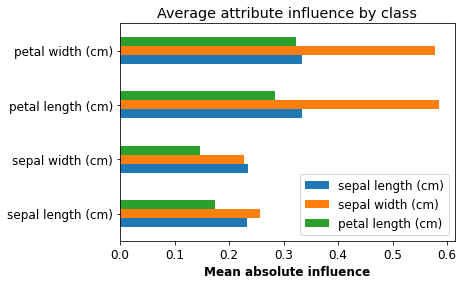

TreeSHAP :


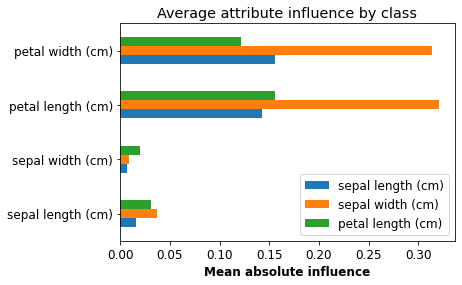

TreeSHAP approx :


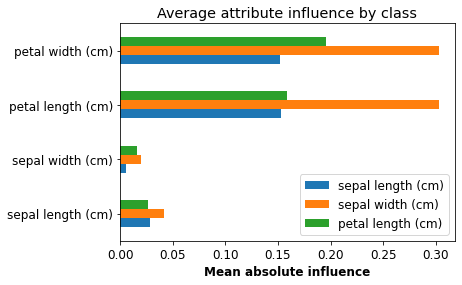

KernelSHAP :


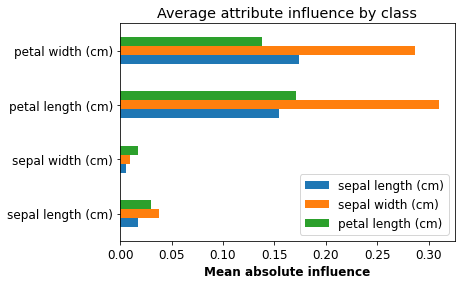

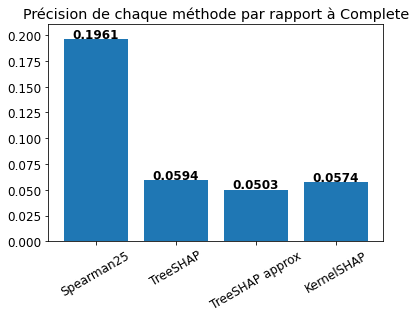

In [12]:
draw_influence(list_shap_values,y, list_influences_names = list_names, labels_names=dataset.feature_names)

## Summary

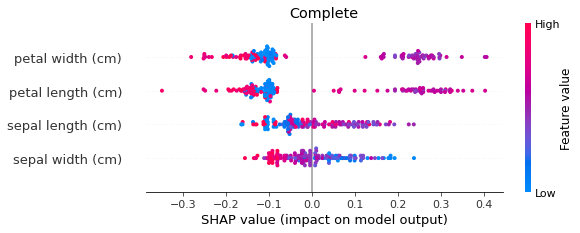

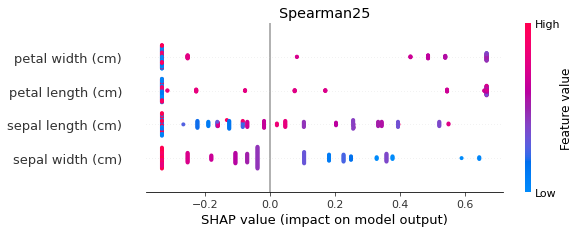

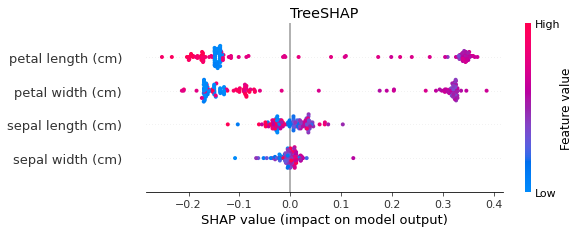

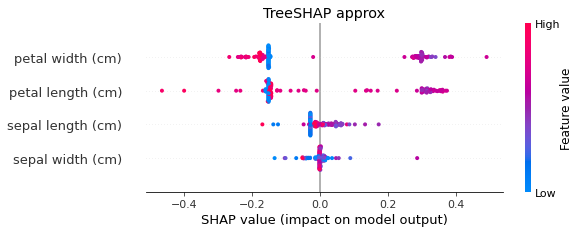

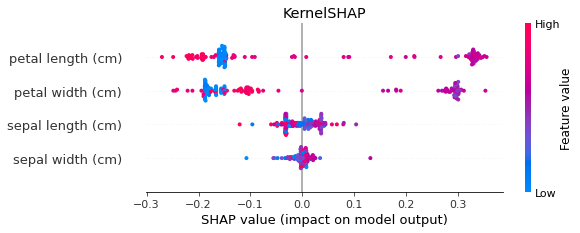

In [13]:
summary_plots(list_shap_values,X,list_names=list_names)

## PDP

In [ ]:
partial_dependance_plots(list_shap_values,X,list_names=list_names)

## Waterfall

In [ ]:
waterfall_plots(list_explanations, clf, X.iloc[:n_echantillons], list_names=list_names, indiv=None)

In [ ]:
waterfall_plots_comparison(list_explanations, clf, X.iloc[:n_echantillons], list_names=list_names, indiv=None)

# Frailty

In [3]:
df = pd.read_csv("../../Fragilite/imputed_datasets/final_df_knn_imputed.csv")
df["frailty"] = (df["friedt0"]>=3).astype(int)
df["frailty3"] = df["friedt0"].map({0:0,1:1,2:1,3:2,4:2,5:2})
random_state = 52
test_size = 0.25

In [4]:
cols_to_drop_age = ["ipp","age"]
cols_to_drop_bin_frailty = ["ipp","friedt0","fried_ppoidst0","fried_fatiguet0","friedepuisement1","friedepuisement2","fried_forcescoret0","fried_apont0","fried_forceont0","fried_vmon","frailty","vmt0","frailty3","sppbt0","iadlt0","adlt0","ageCateg"]
cols_to_drop_tri_frailty = ["ipp","friedt0","fried_ppoidst0","fried_fatiguet0","friedepuisement1","friedepuisement2","fried_forcescoret0","fried_apont0","fried_forceont0","fried_vmon","frailty","vmt0","frailty3","sppbt0","iadlt0","adlt0","ageCateg"]

random_state = 52
test_size = 0.25

X = df.drop(cols_to_drop_bin_frailty,axis=1,errors="ignore")
y = df["frailty"].astype(int)
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)
# X_train_age, X_test_age, y_train_age, y_test_age = model_selection.train_test_split(df.drop(cols_to_drop_age,axis=1,errors="ignore"), df["age"], test_size=test_size, random_state=random_state)

In [5]:
X.shape

(3196, 87)

In [14]:
cols = ['mmset0',
         'peurdetomber',
         'avodt0',
         'avogt0',
         'CRP',
         'hemoglobine',
         'VGM',
         'plaquettes',
         'leucocytes',
         'gdst0',
         'age',
         'nb_ttt']

In [15]:
xgboost.__version__

'1.3.3'

In [81]:
n_echantillons = 100

In [82]:
%%time

explanation_kernel, shap_values_kernel = explanation_values_kernelSHAP(X.iloc[:n_echantillons], clf, look_at=1)

AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

In [32]:
%%time

explanation_spearman, spearman_inf = explanation_values_spearman(X.iloc[:n_echantillons], y.iloc[:n_echantillons], clf, 0.25, "Classification", complexity=True, look_at=1)

Raw influences: 100%|██████████| 1031/1031 [00:01<00:00, 636.86it/s]


Wall time: 44.3 s


In [33]:
%%time

explanation_complete, complete_inf = explanation_values_complete(X.iloc[:n_echantillons], y.iloc[:n_echantillons], clf, "Classification", look_at=1)

Raw influences: 100%|██████████| 4096/4096 [00:06<00:00, 673.23it/s]


Wall time: 20.4 s


## Average attribute influence

In [34]:
list_shap_values = [complete_inf,spearman_inf,shap_values_kernel]
list_names = ["Complete","Spearman25","KernelSHAP"]
list_explanations = [explanation_complete,explanation_spearman,explanation_kernel]

Complete :


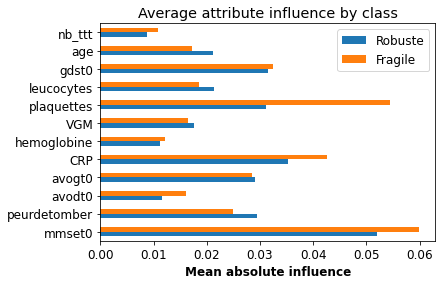

Spearman25 :


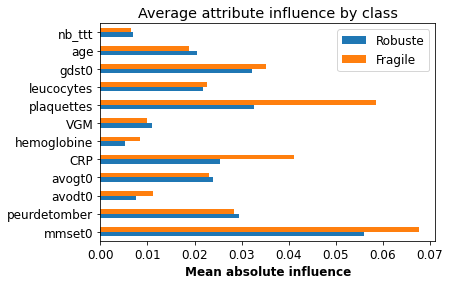

KernelSHAP :


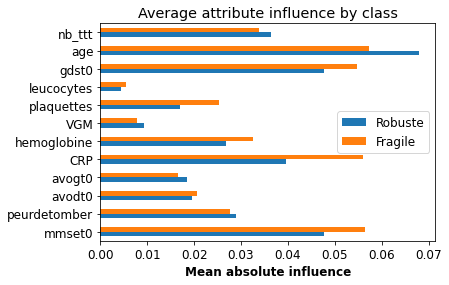

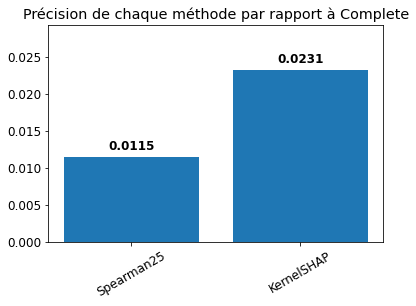

In [35]:
draw_influence(list_shap_values,y, list_influences_names = list_names, labels_names=["Robuste","Fragile"])

## Summary

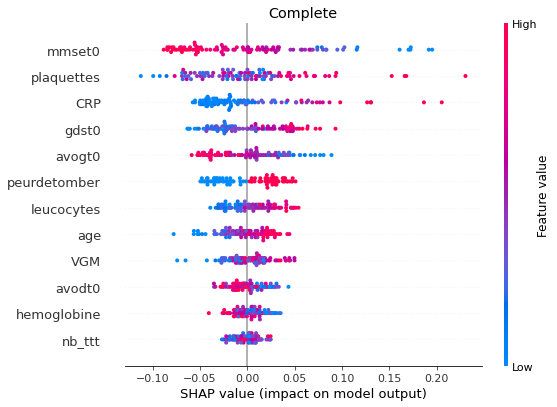

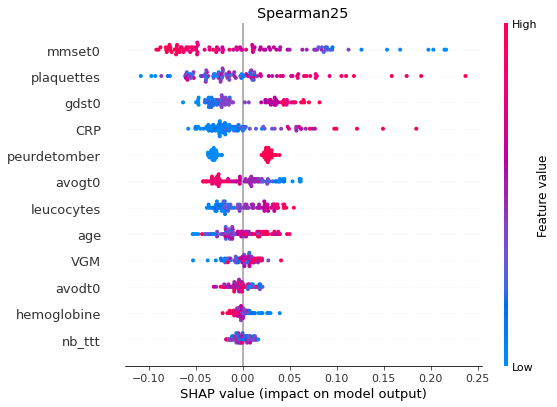

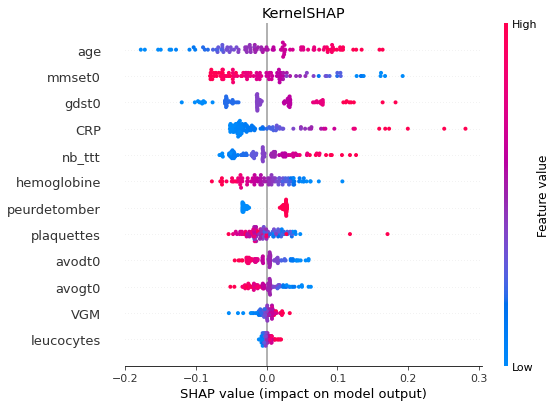

In [36]:
summary_plots(list_shap_values,X.iloc[:n_echantillons],list_names=list_names)

## PDP

In [ ]:
partial_dependance_plots(list_shap_values,X.iloc[:n_echantillons],list_names=list_names)

## Waterfall

In [ ]:
waterfall_plots(list_explanations, clf, list_names=list_names, indiv=None)

In [ ]:
waterfall_plots_comparison(list_explanations, clf, list_names=list_names, indiv=None)